# LLM-Fake-News-Detection-Algorithm

author: Lucca Rallo Vanderchmitt

Python Environment used: Python 3.12.1


# Step 1 - Baseline Classification

This section will fit a logistic regression model with standard pre-processing used in quantitatve text analysis and a simple feature selection plan that weights articles by top TF-IDF scores.

Step 2 will explore more advanced techniques, using Large Language Models.

In [2]:
# importing libraries used in this project:

import pandas as pd
import os
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap



c:\Users\Lucca\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Directory Management

# Define the directory and filenames
data_dir = # insert file path i.e. (r'C:\Users\Lucca\folder\datafolder')
true_path = os.path.join(data_dir, 'True.csv')
fake_path = os.path.join(data_dir, 'Fake.csv')


In [4]:

# Load the datasets
df_true = pd.read_csv(true_path)
df_fake = pd.read_csv(fake_path)

# Display basic info
print("TRUE dataset:")
print(df_true.info())
print(df_true.head())

print("\nFAKE dataset:")
print(df_fake.info())
print(df_fake.head())

TRUE dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politics

In [5]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
# Check dimensions
print("Dimensions of TRUE dataset:", df_true.shape)
print("Dimensions of FAKE dataset:", df_fake.shape)

# Check unique values in 'subject' column
print("\nUnique subjects in TRUE dataset:", df_true['subject'].unique())
print("Unique subjects in FAKE dataset:", df_fake['subject'].unique())

Dimensions of TRUE dataset: (21417, 4)
Dimensions of FAKE dataset: (23481, 4)

Unique subjects in TRUE dataset: ['politicsNews' 'worldnews']
Unique subjects in FAKE dataset: ['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


In [8]:
# Add a label to each dataset: 1 for real, 0 for fake
df_true['label'] = 1
df_fake['label'] = 0

# Combine the datasets
df = pd.concat([df_true, df_fake], axis=0).reset_index(drop=True)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Peek at the data
print(df.head())

                                               title  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...   
1   Failed GOP Candidates Remembered In Hilarious...   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
3  California AG pledges to defend birth control ...   
4  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                                text       subject  \
0  Donald Trump s White House is in chaos, and th...          News   
1  Now that Donald Trump is the presumptive GOP n...          News   
2  Mike Pence is a huge homophobe. He supports ex...          News   
3  SAN FRANCISCO (Reuters) - California Attorney ...  politicsNews   
4  Twisted reasoning is all that comes from Pelos...      politics   

               date  label  
0     July 21, 2017      0  
1       May 7, 2016      0  
2  December 3, 2016      0  
3  October 6, 2017       1  
4      Apr 25, 2017      0  


In [9]:
df.head()

,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


In [10]:
print("Dimensions of merged dataset:", df.shape)

Dimensions of merged dataset: (44898, 5)


Data Preprocessing

In [11]:
# Combine title and text into a single column
df['content'] = df['title'] + " " + df['text']

# Drop the original title and text columns
df = df.drop(['title', 'text'], axis=1)

# Check the shape and null values
print(df.shape)
print(df.isnull().sum())

(44898, 4)
subject    0
date       0
label      0
content    0
dtype: int64


In [12]:
# download NLTK resources
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """Function to clean text data using standard text preprocessing: 
    remove punctuation, text to lowercase and removing stopwords."""

    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

# Apply the cleaning function
df['content'] = df['content'].apply(clean_text)

# Preview cleaned content
print(df['content'].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lucca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    breaking gop chairman grassley enough demands ...
1    failed gop candidates remembered hilarious moc...
2    mike pence’s new dc neighbors hilariously trol...
3    california ag pledges defend birth control ins...
4    az ranchers living usmexico border destroy nan...
Name: content, dtype: object


# Feature Selection: 

Vectorisation using TF-IDF weighting of top 5000 words per article.

In [13]:
# TF-IDF weighting:

# Initialize vectorizer
tfidf = TfidfVectorizer(max_features=5000) # keep only the top 5,000 terms (words) ranked by their TF-IDF scores across the corpus.

# Fit and transform the content
X = tfidf.fit_transform(df['content']).toarray()

# Show shape
print(X.shape)

(44898, 5000)


In [14]:
df.head()

,subject,date,label,content
0,News,"July 21, 2017",0,breaking gop chairman grassley enough demands ...
1,News,"May 7, 2016",0,failed gop candidates remembered hilarious moc...
2,News,"December 3, 2016",0,mike pence’s new dc neighbors hilariously trol...
3,politicsNews,"October 6, 2017",1,california ag pledges defend birth control ins...
4,politics,"Apr 25, 2017",0,az ranchers living usmexico border destroy nan...


In [15]:
# Encode the labels (REAL/FAKE)
y = df['label']
encoder = LabelEncoder()
y = encoder.fit_transform(y)  # FAKE = 0, REAL = 1

print(y[:10])  # Check encoded labels

[0 0 0 1 0 1 1 1 0 0]


# Baseline Model: Logistic Regression


Accuracy Score: 0.9888641425389755

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4669
           1       0.99      0.99      0.99      4311

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Confusion Matrix:
 [[4606   63]
 [  37 4274]]


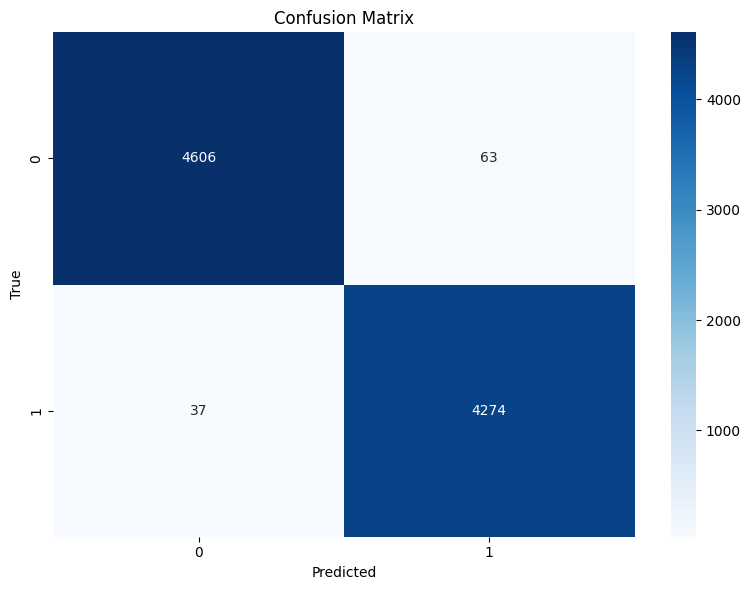

In [16]:
# Model Training
# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)

# 3. Predict
y_pred = model.predict(X_test)

# Model Evaluation
# 4. Evaluate
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = model.classes_  # This will get the unique class labels in order

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


Model Performance by Domain


In [17]:
# Check unique values in 'subject' column
print("\nUnique subjects in TRUE dataset:", df_true['subject'].unique())
print("Unique subjects in FAKE dataset:", df_fake['subject'].unique())

def map_subject_to_domain(subject):
    """Function to map subject to a domain category.
    Note: the subject 'middle-east' is ambigupous and can refer to both politics and news, hence coded to 'other domain' category.,
    """

    if subject in ['politicsNews', 'politics', 'Government News', 'left-news']:
        return 'Politics'
    elif subject in ['US_News', 'News', 'worldnews']:
        return 'News'
    else:
        return 'Other'
    
df['domain'] = df['subject'].apply(map_subject_to_domain)


Unique subjects in TRUE dataset: ['politicsNews' 'worldnews']
Unique subjects in FAKE dataset: ['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


In [18]:
df.head()

,subject,date,label,content,domain
0,News,"July 21, 2017",0,breaking gop chairman grassley enough demands ...,News
1,News,"May 7, 2016",0,failed gop candidates remembered hilarious moc...,News
2,News,"December 3, 2016",0,mike pence’s new dc neighbors hilariously trol...,News
3,politicsNews,"October 6, 2017",1,california ag pledges defend birth control ins...,Politics
4,politics,"Apr 25, 2017",0,az ranchers living usmexico border destroy nan...,Politics


In [19]:
# Attach domains back to test set
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Add true labels and predictions
df_test = df_test.copy()  # to avoid SettingWithCopyWarning
df_test['y_true'] = y_test
df_test['y_pred'] = model.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score, f1_score

performance_by_domain = df_test.groupby('domain').apply(
    lambda g: pd.Series({
        'accuracy': accuracy_score(g['y_true'], g['y_pred']),
        'f1': f1_score(g['y_true'], g['y_pred']),
        'support': len(g)
    })
).reset_index()

print(performance_by_domain)

     domain  accuracy        f1  support
0      News  0.995979  0.996010   3979.0
1     Other  0.986301  0.000000    146.0
2  Politics  0.983110  0.982312   4855.0


C:\Users\Lucca\AppData\Local\Temp\ipykernel_23492\3506773264.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  performance_by_domain = df_test.groupby('domain').apply(


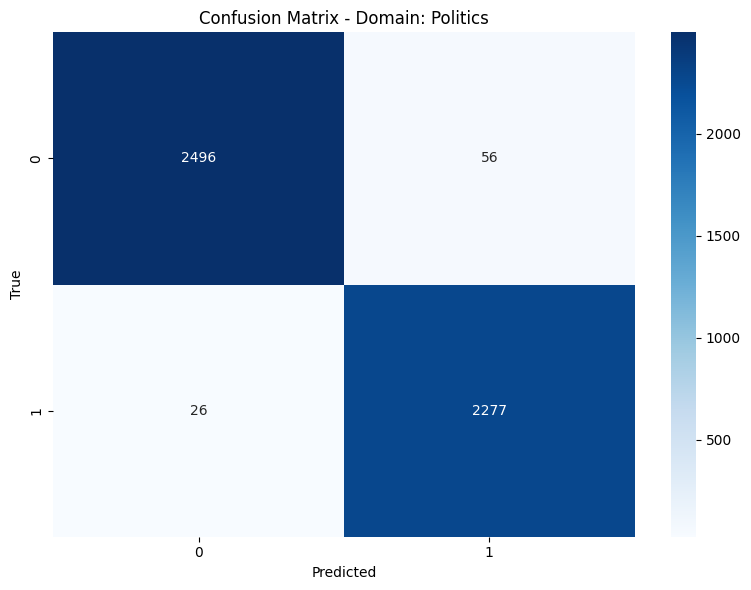

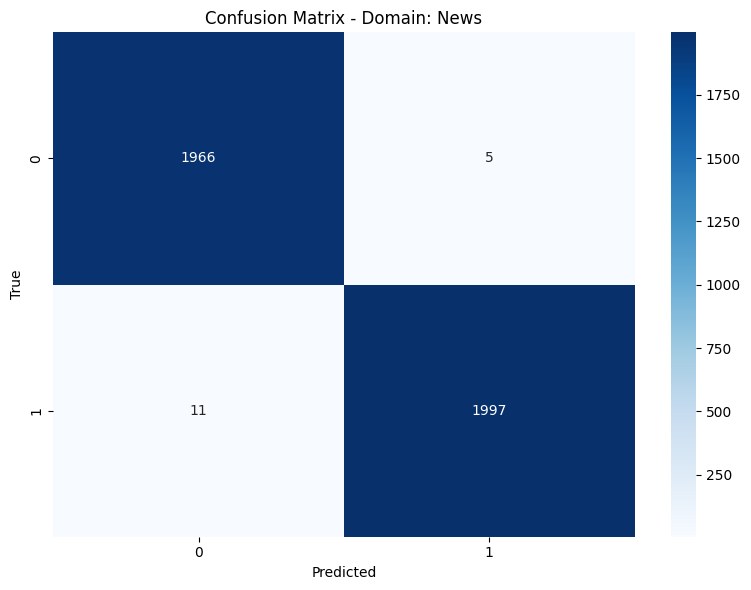

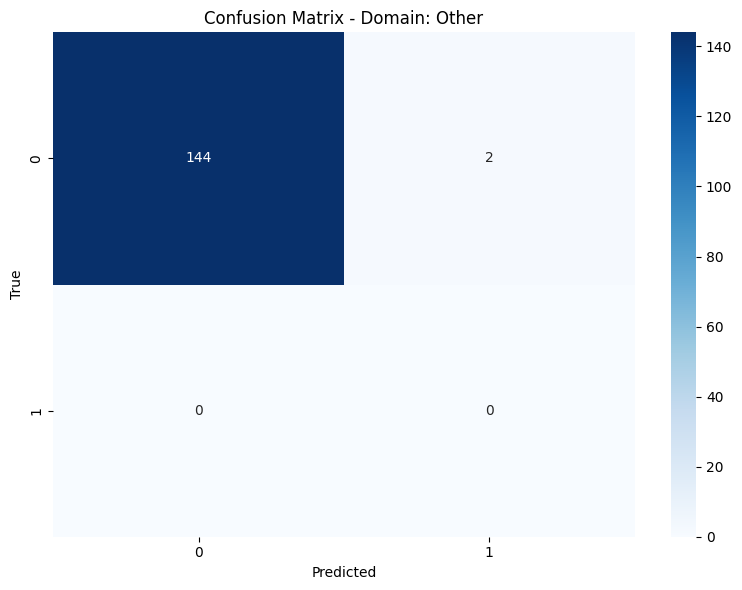

In [21]:
# Ensure df_test has predictions and true labels
df_test = df_test.copy()
df_test['y_pred'] = model.predict(X_test)

# Get model class labels
labels = model.classes_

# Loop through each domain and plot confusion matrix
for domain in df_test['domain'].unique():
    subset = df_test[df_test['domain'] == domain]
    
    cm = confusion_matrix(subset['y_true'], subset['y_pred'], labels=labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Domain: {domain}")
    plt.tight_layout()
    plt.show()


Note: performance for the other domain is biased as it does not include any real news examples.

# Visualising Feature Importance

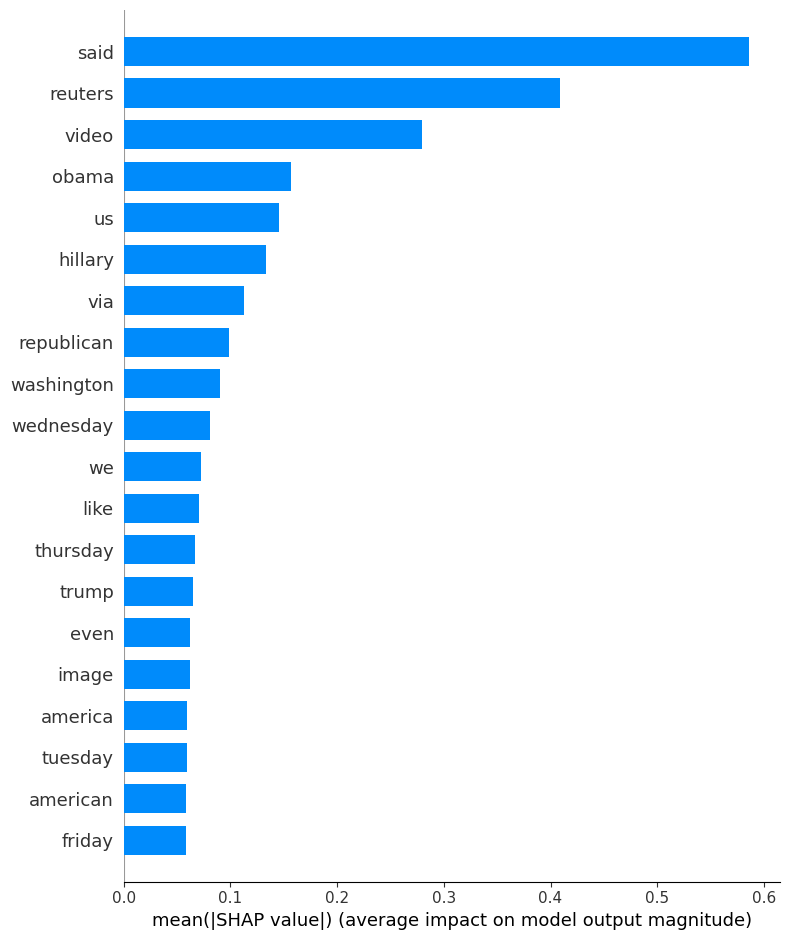

In [22]:
# If you trained the model using a NumPy array, convert X_train and X_test back to DataFrame
X_train_df = pd.DataFrame(X_train, columns=tfidf.get_feature_names_out())
X_test_df = pd.DataFrame(X_test, columns=tfidf.get_feature_names_out())

# Use TreeExplainer for tree-based models, or Explainer for general use
explainer = shap.Explainer(model, X_train_df)
shap_values = explainer(X_test_df)

# Summary plot with proper feature names
shap.summary_plot(shap_values, X_test_df, plot_type="bar")

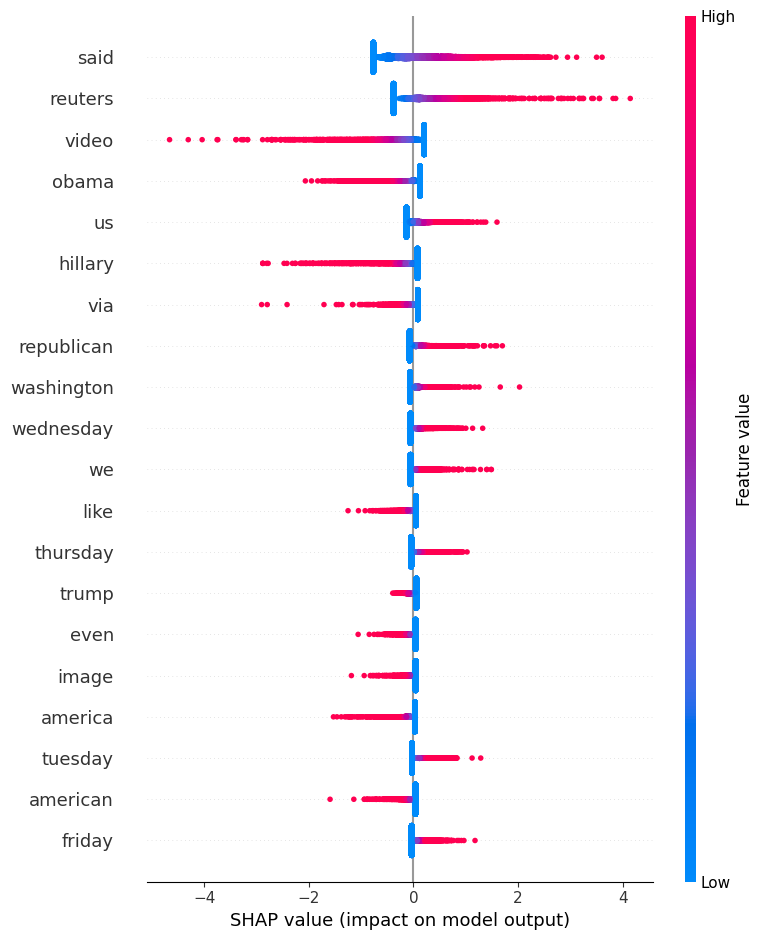

In [23]:
shap.summary_plot(shap_values, X_test_df)

In this SHAP plot:

Negative SHAP values (left side) push the model toward predicting FAKE

Positive SHAP values (right side) push the model toward predicting REAL

The blue bar shows where the model tends to move the prediction when the word is not present.

Red dots show much that word actually influenced the prediction when it was present.
If the red dots are mostly on the right, then the presence of that word pushes the prediction toward real (label = 1).

The SHAP summary plot illustrates the top 20 features influencing the logistic regression model's predictions of fake versus real news. Positive SHAP values indicate words that push predictions toward real news, while negative values push toward fake news. The model associates terms like “said”, “reuters”, and “via” with real news, reflecting journalistic conventions and credible sourcing. In contrast, terms such as “video”, “obama”, “hillary”, and “image” are strongly associated with fake news, suggesting the model detects patterns tied to sensationalism and political clickbait. The presence of weekday names appears to have a more neutral or mixed effect as would be expected. Overall, the model captures some meaningful linguistic and stylistic cues that differentiate real from fake articles.

# Step 2 - Improvement 

This section will focus on improving the first model's predictions by focusing on the missclassified articles specifically and using more advanced techniques for text classification: Large Language Models (LLMs).

Traditional models like logistic regression, when based on TF-IDF representations, treat words as independent features and fail to capture contextual meaning, syntax, and word order. To overcome this, I introduce a Large Language Model (LLM) that leverages deep contextual understanding and semantic nuance in text classification. 

I will use the LLM GPT-4o-mini which balances cost and performance quite well.

In [24]:
# Identify Incorrect Predictions

# Add a boolean column for correctness
df_test['correct'] = df_test['y_true'] == df_test['y_pred']

# Filter misclassified examples
df_misclassified = df_test[~df_test['correct']].copy()

# Show a preview
print(f"Number of misclassified articles: {len(df_misclassified)}")

Number of misclassified articles: 100


In [25]:
df_misclassified.head()

,subject,date,label,content,domain,y_true,y_pred,correct
42953,politicsNews,"September 16, 2016",1,londons muslim mayor backs clinton us presiden...,Politics,1,0,False
22935,left-news,"Jun 26, 2016",0,iceland’s stunning election antiestablishment ...,Politics,0,1,False
16145,politics,"Jul 11, 2015",0,chinese immigrant owes millions selling counte...,Politics,0,1,False
216,left-news,"Mar 30, 2017",0,vice president pence breaks tie bill allowing ...,Politics,0,1,False
6757,Government News,"Jul 25, 2017",0,massachusetts votes ignore fed law let illegal...,Politics,0,1,False


# LLM query using data modelling and validation framework: Pydantic

This framework allows for structured API calls to the LLM, ensuring greater reliability and consistency in the results.

In [26]:
import os
import pandas as pd
from enum import Enum
from typing import List
from pydantic import BaseModel, Field
from openai import OpenAI
import instructor
from dotenv import load_dotenv
from typing import Optional
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
# API Key Setup

# For replication: insert API key here

# Load environment variables from the .env file
load_dotenv()

# Get the API key from the environment
api_key = os.getenv("OPENAI_API_KEY")

# Patch OpenAI client with instructor
client = instructor.patch(OpenAI(api_key=api_key))

completion = client.chat.completions.create(
  model="gpt-4o-mini",
  store=True,
  messages=[
    {"role": "user", "content": "write a haiku about ai"}
  ]
)

print(completion.choices[0].message)

ChatCompletionMessage(content='Lines of code entwined,  \nSilent mind of circuitry,  \nDreams of logic soar.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None)


In [44]:
class NewsDetect(str, Enum):
    FAKE_NEWS = "fake_news"
    REAL_NEWS = "real_news"
    UNCLEAR = "unclear"


class TextClassification(BaseModel):
    news_class: NewsDetect
    confidence: float = Field(ge=0, le=1, description="Confidence score for the classification")
  


SYSTEM_PROMPT_TEXT = """
You are an expert in detecting fake and real news articles. Your task is to classify whether a given article is most likely:

1. **fake_news** – Content that is likely false, misleading, conspiratorial, or intentionally deceptive.
2. **real_news** – Credible, factual reporting from established or trustworthy sources.
3. **unclear** – Articles where the classification is ambiguous due to lack of context, sarcasm, or insufficient information.

Respond ONLY in valid JSON format like this:

{
  "news_class": "fake_news",
  "confidence": 0.87
}

Where:
- `news_class` is one of: `"fake_news"`, `"real_news"`, or `"unclear"`
- `confidence` is a number between 0 and 1

Do not explain your reasoning. Just return the JSON output only.
"""


# Classification function
def classify_text(text: str) -> TextClassification:
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        response_model=TextClassification,
        temperature=0,
        max_retries=2,
        messages=[
            {
                "role": "system",
                "content": SYSTEM_PROMPT_TEXT,
            },
            {"role": "user", "content": text}
        ]
    )
    return response

In [47]:
from tqdm import tqdm
tqdm.pandas()  # progress bar 

# Define helper to extract prediction and confidence
def classify_row(text):
    try:
        result = classify_text(text)
        return result.news_class.value, result.confidence
    except Exception as e:
        return "error", 0.0

# Apply classification
df_misclassified[['llm_prediction', 'llm_confidence']] = df_misclassified['content'].progress_apply(
    lambda x: pd.Series(classify_row(x))
)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


In [48]:
df_misclassified.head()

,subject,date,label,content,domain,y_true,y_pred,correct,llm_prediction,llm_confidence
42953,politicsNews,"September 16, 2016",1,londons muslim mayor backs clinton us presiden...,Politics,1,0,False,real_news,0.85
22935,left-news,"Jun 26, 2016",0,iceland’s stunning election antiestablishment ...,Politics,0,1,False,real_news,0.85
16145,politics,"Jul 11, 2015",0,chinese immigrant owes millions selling counte...,Politics,0,1,False,fake_news,0.85
216,left-news,"Mar 30, 2017",0,vice president pence breaks tie bill allowing ...,Politics,0,1,False,real_news,0.85
6757,Government News,"Jul 25, 2017",0,massachusetts votes ignore fed law let illegal...,Politics,0,1,False,fake_news,0.85


Map LLM predictions to binary labels

In [49]:
# Map LLM predictions to 0 = fake, 1 = real
label_map = {
    "fake_news": 0,
    "real_news": 1
}

df_eval = df_misclassified[df_misclassified['llm_prediction'].isin(label_map.keys())].copy()
df_eval['llm_pred_binary'] = df_eval['llm_prediction'].map(label_map)

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_true = df_eval['label']
y_pred = df_eval['llm_pred_binary']

# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))

# Print accuracy
print("Accuracy Score:", accuracy_score(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Classification Report:

              precision    recall  f1-score   support

        Fake       0.91      0.47      0.62        62
        Real       0.51      0.92      0.65        37

    accuracy                           0.64        99
   macro avg       0.71      0.69      0.64        99
weighted avg       0.76      0.64      0.63        99

Accuracy Score: 0.6363636363636364
Confusion Matrix:
 [[29 33]
 [ 3 34]]


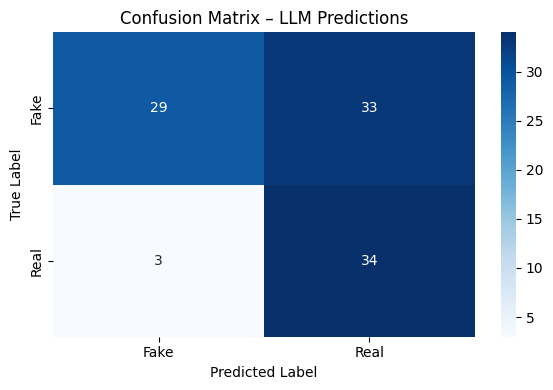

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – LLM Predictions")
plt.tight_layout()
plt.show()

Performance by domain:

In [55]:
# Define the label mapping
label_map = {
    "fake_news": 0,
    "real_news": 1
}

# Create binary column only for valid predictions
df_misclassified = df_misclassified.copy()
df_misclassified['llm_pred_binary'] = df_misclassified['llm_prediction'].map(label_map)

from sklearn.metrics import accuracy_score, f1_score

# Filter to rows with valid binary predictions
df_eval = df_misclassified[df_misclassified['llm_pred_binary'].notnull()]

performance_by_domain_llm = df_eval.groupby('domain', group_keys=False).apply(
    lambda g: pd.Series({
        'accuracy': accuracy_score(g['label'], g['llm_pred_binary']),
        'f1': f1_score(g['label'], g['llm_pred_binary'], zero_division=0),
        'support': len(g)
    })
).reset_index()

print(performance_by_domain_llm)


     domain  accuracy        f1  support
0      News  0.875000  0.916667     16.0
1     Other  1.000000  0.000000      2.0
2  Politics  0.580247  0.575000     81.0


C:\Users\Lucca\AppData\Local\Temp\ipykernel_23492\2358200007.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  performance_by_domain_llm = df_eval.groupby('domain', group_keys=False).apply(


# Results Interpretation: LLM performance

The results indicate that the LLM achieved an accuracy of 64% on these difficult cases, which the the logisitc regression missclassified — a notable improvement over the baseline model, which by definition had 0% accuracy on this subset.

More importantly, the confusion matrix and classification report reveal a key strength of the LLM:

It correctly classifies a large proportion of real news articles, with a recall of 0.92 for the real class, meaning it recovered nearly all real articles that the logistic regression model had previously mislabeled.

It also shows strong precision for fake news (0.91), meaning when it predicts fake, it's usually correct — even though its recall for fake is lower (0.47), meaning it misses some fake cases.

This indicates a more balanced understanding of the real/fake distinction, where the LLM is especially effective at recognizing real news among previously misclassified items.

**By domain:**

In the News domain, the LLM performs strongly, with high accuracy and F1-score, suggesting it can reliably detect real news cues and correct prior model errors in that context.

In the Politics domain, which constitutes the bulk of examples, performance is lower — precision and recall are more balanced, but the domain remains challenging, likely due to nuanced language, satire, or politicized misinformation.

In the Other category, the LLM achieves perfect accuracy but on a very small number of samples (n = 2), so this result should be interpreted cautiously.


# Extension: Assessing LLM classification performance on highly confident predictions

In [57]:
df_misclassified['llm_confidence'].describe()

count    100.000000
mean       0.861800
std        0.049408
min        0.500000
25%        0.850000
50%        0.850000
75%        0.850000
max        0.950000
Name: llm_confidence, dtype: float64

In [66]:
df_misclassified_conf = df_misclassified[df_misclassified['llm_confidence'] >= 0.90].copy()
print(f"Remaining rows after filtering: {len(df_misclassified_conf)}")

Remaining rows after filtering: 22


Classification Report:

              precision    recall  f1-score   support

        Fake       1.00      0.67      0.80         3
        Real       0.95      1.00      0.97        19

    accuracy                           0.95        22
   macro avg       0.97      0.83      0.89        22
weighted avg       0.96      0.95      0.95        22

Accuracy Score: 0.9545454545454546
Confusion Matrix:
 [[ 2  1]
 [ 0 19]]


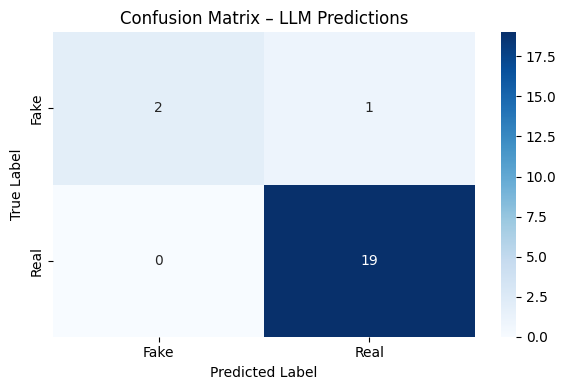

In [64]:
df_eval = df_misclassified_conf[df_misclassified_conf['llm_prediction'].isin(label_map.keys())].copy()
df_eval['llm_pred_binary'] = df_eval['llm_prediction'].map(label_map)

y_true = df_eval['label']
y_pred = df_eval['llm_pred_binary']

# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))

# Print accuracy
print("Accuracy Score:", accuracy_score(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – LLM Predictions")
plt.tight_layout()
plt.show()

# Results Interpretation: High Confidence LLM predictions

When filtering the LLM's predictions to include only those with a confidence score above 0.90, the model demonstrates very strong performance on this subset of previously misclassified articles:

Accuracy reaches 95%, indicating that the model is highly reliable when it is confident.

Precision is perfect (1.00) for fake news and very high (0.95) for real news, showing that high-confidence predictions are rarely incorrect.

Recall for real news is 1.00, meaning all real news articles were correctly identified.

Despite the small sample size (n = 22), these results suggest that the LLM’s confidence score is a meaningful indicator of prediction reliability. In practical terms, the LLM could be used as a selective classifier — automatically labeling only those articles it is highly confident about, while deferring uncertain cases to human review or additional models.

# Discussion and Conclusion


The baseline logistic regression model achieved near-perfect performance, with an accuracy of 98.9% and F1-scores of 0.99 for both fake and real news classes. The model relied on a TF-IDF representation of the text, capturing frequency-based word importance. Visualising the SHAP values provided further insight into its decision-making process: terms like “said”, “reuters”, and “via” — indicative of journalistic standards — pushed predictions toward real news, while words like “video”, “hillary”, and “obama” were associated with fake news, highlighting the model’s sensitivity to emotionally charged or clickbait-style content. These results demonstrate that even simple linear models can perform exceptionally well on linearly separable tasks, especially when trained on well-labeled, balanced datasets.

However, model performance on the overall test set may obscure critical weaknesses — especially regarding borderline or ambiguous examples. To address this, I focused on the subset of test examples that the logistic regression model misclassified, applying a Large Language Model (LLM) to determine whether it could recover those errors using more nuanced semantic understanding.

The LLM achieved an accuracy of 64% on these misclassified articles — an impressive recovery considering this subset represents the most challenging cases. It showed strong recall for real news (0.92) and high precision for fake news (0.91), suggesting that the LLM complements the baseline model by correcting many of its errors, particularly for real news detection.

When disaggregating performance by domain, the LLM was most effective in the News category, with strong accuracy and F1-scores. In the Politics domain, performance was more variable, likely due to complex rhetoric and satire.

Filtering LLM predictions to include only those with confidence scores above 90% resulted in even more impressive outcomes. On this high-confidence subset, the LLM achieved 95% accuracy, with perfect precision for fake news and 100% recall for real news. This suggests that confidence scores could serve as a practical filter for model deployment — allowing automatic classification of high-confidence cases while deferring uncertain predictions for human or ensemble review.

In conclusion, while the logistic regression model is a strong and efficient baseline, the LLM offers valuable improvements, particularly in its ability to recover misclassified examples and provide reliable predictions when confident. A hybrid approach — using logistic regression for general classification and LLMs for ambiguous or low-confidence cases — could maximize both efficiency and accuracy in real-world fake news detection systems.